## Extensions and problems

This section introduces more complicated types of variables and relationships. We will use three datasets for illustration:
1. The `Advertising` dataset that has been used in the previous sections. 
2. The `Credit` dataset contains information about credit card holders. The goal is to predict the credit `Limit` for each card holder. 
3. The `Auto` dataset contains information about the characteristics of cars. The goal is to predict the `mpg` (miles per gallon) for a car based on its features like `horsepower`, `weight` and `acceleration`. This dataset is also used in the  tutorial of {doc}`Prerequisites <../00-prereq/overview>`.

### Import the required libraries and load datasets.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression

from statsmodels.formula.api import ols

%matplotlib inline

**Load `Advertising`, `Credit`, and `Auto` datasets**. 
<!-- Datasets available on https://www.statlearning.com/resources-first-edition -->

In [ ]:
data_url = "https://github.com/pykale/transparentML/raw/main/data/Advertising.csv"
advertising_df = pd.read_csv(data_url, header=0, index_col=0)

In [ ]:
credit_url = "https://github.com/pykale/transparentML/raw/main/data/Credit.csv"

credit_df = pd.read_csv(credit_url)
credit_df["Student2"] = credit_df.Student.map({"No": 0, "Yes": 1})
credit_df.head(3)

In [ ]:
auto_url = "https://github.com/pykale/transparentML/raw/main/data/Auto.csv"

auto_df = pd.read_csv(auto_url, na_values="?").dropna()
auto_df.info()

### Qualitative predictors

In the previous sections, the predictor variables are *quantitative*. For example, in the `Credit` dataset, the response is `Balance` (average credit card debt for each individual) and there are six quantitative predictors: `Age` , `Cards` (number of credit cards), `Education` (years of education), `Income` (in thousands of dollars), `Limit` (credit limit), and `Rating` (credit rating). The following code displays the pairwise relationships between these variables (Figure 3.6 in the textbook).

In [ ]:
sns.pairplot(
    credit_df[["Balance", "Age", "Cards", "Education", "Income", "Limit", "Rating"]]
)

However, in practice, predictor variables are not always quantitative. For example in `Credit` dataset, it also contains four qualitative variables: `Student` (`Yes` or `No`), `Own` (`Yes` or `No`), `Married` (`Yes` or `No`), and `Region` (`South`, `East`, or `West`).

**Predictors with only two levels**

Run the following Least squares coefficient estimates associated with the regression of `Balance` onto `Own` in the `Credit` data set (Table 3.7 in the textbook).

In [ ]:
est = ols("Balance ~ Own", credit_df).fit()
est.summary().tables[1]

**Predictors with more than two levels**

Run the following Least squares coefficient estimates associated with the regression of `Balance` onto `Region` in the `Credit` data set (Table 3.8 in the textbook).

In [ ]:
est = ols("Balance ~ Region", credit_df).fit()
est.summary().tables[1]

### Extensions of linear regression

#### Interaction between variables

In the previous analysis of `Advertising` dataset, the predictor variables are assumed to be independent. However, this model may be incorrect. For example, `radio` advertising can increase the effectiveness of `TV` advertising, which is known as *interaction* effect in statistics. Consider the a standard multiple linear regression with two variables

$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \epsilon.
$$

This model can be extended to include an interaction term between $x_1$ and $x_2$:

\begin{align}
y &= \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_1 x_2 + \epsilon \\
&= \beta_0 + (\beta_1 + \beta_3 x_2) x_1 + \beta_2 x_2 + \epsilon \\
&= \beta_0 + \tilde{\beta}_1 x_1 + \beta_2 x_2 + \epsilon,
\end{align}

where $\tilde{\beta}_1 = \beta_1 + \beta_3 x_2$ is the *effective* coefficient on $x_1$. Then the association between $y$ and $x_1$ is no longer constant and depends on the value of $x_2$. Similarly, the association between $y$ and $x_2$ is no longer constant and depends on the value of $x_1$.

Run the following code for the `Advertising` data, least squares coefficient estimates associated with the regression of sales onto `TV` and `Radio`, with an interaction term, `TV` $\times$ `Radio` (Table 3.9 of the text book).

In [ ]:
est = ols("Sales ~ TV + Radio + TV*Radio", advertising_df).fit()
est.summary().tables[1]

#### Interaction between qualitative and quantitative variables

The concept of interactions applies just as well to qualitative variables. In fact, sometimes an interaction between a qualitative variable and a quantitative variable has a particularly nice interpretation. For example, run the following code to predict `Balance` using the `Income` (quantitative) and `Student` (qualitative) variables, and compare the differences between including and excluding the interaction term between `Income` and `Student` (Figure 3.7 of the textbook).

In [ ]:
est1 = ols("Balance ~ Income + Student2", credit_df).fit()
est2 = ols("Balance ~ Income + Income*Student2", credit_df).fit()

print("Regression 1 - without interaction term")
print(est1.params)
print("\nRegression 2 - with interaction term")
print(est2.params)

In [ ]:
# Income (x-axis)
regr1 = est1.params
regr2 = est2.params

income = np.linspace(0, 150)

# Balance without interaction term (y-axis)
student1 = np.linspace(
    regr1["Intercept"] + regr1["Student2"],
    regr1["Intercept"] + regr1["Student2"] + 150 * regr1["Income"],
)
non_student1 = np.linspace(
    regr1["Intercept"], regr1["Intercept"] + 150 * regr1["Income"]
)

# Balance with interaction term (y-axis)
student2 = np.linspace(
    regr2["Intercept"] + regr2["Student2"],
    regr2["Intercept"]
    + regr2["Student2"]
    + 150 * (regr2["Income"] + regr2["Income:Student2"]),
)
non_student2 = np.linspace(
    regr2["Intercept"], regr2["Intercept"] + 150 * regr2["Income"]
)

# Create plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(income, student1, "r", income, non_student1, "k")
ax2.plot(income, student2, "r", income, non_student2, "k")

for ax in fig.axes:
    ax.legend(["student", "non-student"], loc=2)
    ax.set_xlabel("Income")
    ax.set_ylabel("Balance")
    ax.set_ylim(ymax=1550)

#### Non-linear relationships

In some cases, the true relationship between the response and the predictors may be non-linear. Here we present a very simple way to directly extend the linear model to accommodate non-linear relationships, using *polynomial regression*.

Run the following code to display the relationship between `mpg` (gas mileage in miles per gallon) and different degrees of `horsepower` (Figure 3.8 of the textbook) for a number of cars in the `Auto` dataset.

In [ ]:
# With Seaborn's regplot() you can easily plot higher order polynomials.
plt.scatter(
    auto_df.horsepower, auto_df.mpg, facecolors="None", edgecolors="k", alpha=0.5
)
sns.regplot(
    x=auto_df.horsepower,
    y=auto_df.mpg,
    ci=None,
    label="Linear",
    scatter=False,
    color="orange",
)
sns.regplot(
    x=auto_df.horsepower,
    y=auto_df.mpg,
    ci=None,
    label="Degree 2",
    order=2,
    scatter=False,
    color="lightblue",
)
sns.regplot(
    x=auto_df.horsepower,
    y=auto_df.mpg,
    ci=None,
    label="Degree 5",
    order=5,
    scatter=False,
    color="g",
)
plt.legend()
plt.ylim(5, 55)
plt.xlim(40, 240);

The figure seem to suggest that a quadratic relationship between `mpg` and `horsepower` might be more appropriate than a linear relationship. We can fit such a model using the following regression:

\begin{equation}
\textrm{mpg} = \beta_0 + \beta_1 \times \textrm{horsepower} + \beta_2 \times \textrm{horsepower}^2 + \epsilon.
\end{equation}

In fact, this is still a linear model with $x_1 = \textrm{horsepower}$ and $x_2 = \textrm{horsepower}^2$. Run the following code to fit a linear regression model with `mpg` as the response and `horsepower` and `horsepower^2` as the predictors (Table 3.10 of the textbook).

In [ ]:
auto_df["horsepower2"] = auto_df.horsepower**2
auto_df.head(3)

In [ ]:
est = ols("mpg ~ horsepower + horsepower2", auto_df).fit()
est.summary().tables[1]

### Problems of linear regression

#### Non-linearity of the Data
  
The linear regression model assumes that there is a straight-line relationship between the predictors and the response. If the true relationship is far from linear, then virtually all of the conclusions that we draw from the fit are suspect. In addition, the prediction accuracy of the model can be significantly reduced.

Run the following code to compare the differences in accuracy between a linear regression model and a quadratic regression model for regressing `mpg` onto `horsepower`.

Firstly, fitting a linear regression model and a quadratic regression model for regressing `mpg` onto `horsepower` and compute the residuals for each model.

In [ ]:
regr = LinearRegression()

# Linear fit
X = auto_df.horsepower.values.reshape(-1, 1)
y = auto_df.mpg
regr.fit(X, y)

auto_df["pred1"] = regr.predict(X)
auto_df["resid1"] = auto_df.mpg - auto_df.pred1

# Quadratic fit
X2 = auto_df[["horsepower", "horsepower2"]].values
regr.fit(X2, y)

auto_df["pred2"] = regr.predict(X2)
auto_df["resid2"] = auto_df.mpg - auto_df.pred2

Create plots of the residuals for each model. What do you observe?

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Left plot
sns.regplot(
    x=auto_df.pred1,
    y=auto_df.resid1,
    lowess=True,
    ax=ax1,
    line_kws={"color": "r", "lw": 1},
    scatter_kws={"facecolors": "None", "edgecolors": "k", "alpha": 0.5},
)
ax1.hlines(
    0,
    xmin=ax1.xaxis.get_data_interval()[0],
    xmax=ax1.xaxis.get_data_interval()[1],
    linestyles="dotted",
)
ax1.set_title("Residual Plot for Linear Fit")

# Right plot
sns.regplot(
    x=auto_df.pred2,
    y=auto_df.resid2,
    lowess=True,
    line_kws={"color": "r", "lw": 1},
    ax=ax2,
    scatter_kws={"facecolors": "None", "edgecolors": "k", "alpha": 0.5},
)
ax2.hlines(
    0,
    xmin=ax2.xaxis.get_data_interval()[0],
    xmax=ax2.xaxis.get_data_interval()[1],
    linestyles="dotted",
)
ax2.set_title("Residual Plot for Quadratic Fit")

for ax in fig.axes:
    ax.set_xlabel("Fitted values")
    ax.set_ylabel("Residuals")

```{Admonition} How to interpret the plots?
:class: tip, dropdown
- The left panel of displays a residual plot from the linear regression of `mpg` onto `horsepower` on the `Auto` dataset. The red line is a smooth fit to the residuals, which is displayed in
order to make it easier to identify any trends. The residuals exhibit a clear U-shape, which provides a strong indication of non-linearity in the data.
- The right-hand panel displays the residual plot that results from the model contains a quadratic term. There appears to be little pattern in the residuals, suggesting that the quadratic term improves the fit to the data.
```

#### Collinearity
  
Collinearity refers to the situation in which two or more predictor variables are closely related to one another. 
  
 Run the following code to illustrate the problem of collinearity in the `Credit` dataset (Figure 3.14 of the textbook). In the left-hand panel, the two predictors `limit` and `age` appear to have no obvious relationship. In contrast, in the right-hand panel, the predictors `limit` and `rating` are very highly correlated with each other, and we say that they are *collinear*. In this context, `limit` and `rating` tend to increase or decrease together, it can be difficult to determine how each one separately is associated with the response, `balance`.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Left plot
ax1.scatter(credit_df.Limit, credit_df.Age, facecolor="None", edgecolor="r")
ax1.set_ylabel("Age")

# Right plot
ax2.scatter(credit_df.Limit, credit_df.Rating, facecolor="None", edgecolor="r")
ax2.set_ylabel("Rating")

for ax in fig.axes:
    ax.set_xlabel("Limit")
    ax.set_xticks([2000, 4000, 6000, 8000, 12000])

Run following code to learn the difficulties that can result from collinearity in the context of the `Credit` dataset (Table 3.11 of the textbook).

In [ ]:
y = credit_df.Balance

# Regression for left plot
X = credit_df[["Age", "Limit"]].values
regr1 = LinearRegression()
regr1.fit(scale(X.astype("float"), with_std=False), y)
print("Age/Limit\n", regr1.intercept_)
print(regr1.coef_)

# Regression for right plot
X2 = credit_df[["Rating", "Limit"]].values
regr2 = LinearRegression()
regr2.fit(scale(X2.astype("float"), with_std=False), y)
print("\nRating/Limit\n", regr2.intercept_)
print(regr2.coef_)

Create grid coordinates for plotting and then calculate RSS based on grid of coefficients

In [ ]:
# grid coordinates
beta_age = np.linspace(regr1.coef_[0] - 3, regr1.coef_[0] + 3, 100)
beta_limit = np.linspace(regr1.coef_[1] - 0.02, regr1.coef_[1] + 0.02, 100)

beta_rating = np.linspace(regr2.coef_[0] - 3, regr2.coef_[0] + 3, 100)
beta_limit2 = np.linspace(regr2.coef_[1] - 0.2, regr2.coef_[1] + 0.2, 100)

X1, Y1 = np.meshgrid(beta_limit, beta_age, indexing="xy")
X2, Y2 = np.meshgrid(beta_limit2, beta_rating, indexing="xy")
Z1 = np.zeros((beta_age.size, beta_limit.size))
Z2 = np.zeros((beta_rating.size, beta_limit2.size))

limit_scaled = scale(credit_df.Limit.astype("float"), with_std=False)
age_scaled = scale(credit_df.Age.astype("float"), with_std=False)
rating_scaled = scale(credit_df.Rating.astype("float"), with_std=False)

# calculate RSS
for (i, j), v in np.ndenumerate(Z1):
    Z1[i, j] = (
        (y - (regr1.intercept_ + X1[i, j] * limit_scaled + Y1[i, j] * age_scaled)) ** 2
    ).sum() / 1000000

for (i, j), v in np.ndenumerate(Z2):
    Z2[i, j] = (
        (y - (regr2.intercept_ + X2[i, j] * limit_scaled + Y2[i, j] * rating_scaled))
        ** 2
    ).sum() / 1000000

Plot the contours of the RSS with respect to the coefficients of the two linear regression models in 2D.

In [ ]:
from matplotlib.pyplot import contour


fig = plt.figure(figsize=(12, 5))
fig.suptitle("RSS - Regression coefficients", fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

min_RSS = r"$\beta_0$, $\beta_1$ for minimized RSS"

# Left plot
contour1 = ax1.contour(X1, Y1, Z1, cmap=plt.cm.Set1, levels=[21.25, 21.5, 21.8])
ax1.scatter(regr1.coef_[1], regr1.coef_[0], c="r", label=min_RSS)
ax1.clabel(contour1, inline=True, fontsize=10, fmt="%1.1f")
ax1.set_ylabel(r"$\beta_{Age}$", fontsize=17)

# Right plot
contour2 = ax2.contour(X2, Y2, Z2, cmap=plt.cm.Set1, levels=[21.5, 21.8])
ax2.scatter(regr2.coef_[1], regr2.coef_[0], c="r", label=min_RSS)
ax2.clabel(contour2, inline=True, fontsize=10, fmt="%1.1f")
ax2.set_ylabel(r"$\beta_{Rating}$", fontsize=17)
ax2.set_xticks([-0.1, 0, 0.1, 0.2])

for ax in fig.axes:
    ax.set_xlabel(r"$\beta_{Limit}$", fontsize=17)
    ax.legend()

Left: A contour plot of RSS for the regression of `balance` onto `age` and `limit`. The minimum value is well defined. Right: A contour plot of RSS for the regression of `balance` onto `rating` and `limit`. Because of the collinearity, there are many pairs ($\beta_{\text{Limit}}$ , $\beta_{\text{Rating}}$) with a similar value for RSS.

Collinearity reduces the accuracy of the estimates of the regression coefficients, it causes the standard error for $\hat{\beta}_j$ to grow. in the presence of collinearity, we may fail to reject $H_0$ : $\hat{\beta}_j = 0$. This means that the power of the hypothesis test—the probability of correctly power detecting a non-zero coefficient is reduced by collinearity.

Run the following code to compare the coefficient estimates obtained from two separate multiple regression models, where the first model is a regression of `balance` on `age` and `limit`, and the second model is a regression of `balance` on `rating` and `limit`.

In [ ]:
est_age_limit = ols("Balance ~ Age + Limit", credit_df).fit()
est_age_limit.summary().tables[1]

In [ ]:
est_rating_limit = ols("Balance ~ Rating + Limit", credit_df).fit()

# est_limit = ols("Limit ~ Age + Rating", credit_df).fit()

# print(1 / (1 - est_rating.rsquared))
# print(1 / (1 - est_age.rsquared))
# print(1 / (1 - est_limit.rsquared))

est_rating_limit.summary().tables[1]

```{admonition} How to interpret the results? 
:class: tip, dropdown
In the first regression, both `age` and `limit` are highly significant with very small p-values. In the second, the collinearity between `limit` and `rating` has caused the standard error for the `limit` coefficient estimate to increase by a factor of 12 and the p-value to increase to 0.701. In other words, the importance of the `limit` variable has been masked due to the presence of collinearity.
```

### Exercise

**1**. This question involves the use of simple linear regression on the **Auto** dataset from [Tabel 1.2](https://pykale.github.io/transparentML/01-intro/organisation.html#datasets-table).

**a**. Use the **LinearRegression()** function to perform a simple linear regression with **mpg** as the response and **horsepower** as the predictor. Use the **summary()** function to print the results. Comment on the output.

   For example:

   >i. Is there a relationship between the predictor and the response?

   >ii. How strong is the relationship between the predictor and the response?

   >iii. Is the relationship between the predictor and the response positive or negative?

In [ ]:
# Write your code below to answer the question

Compare your answer with the reference solution below

In [ ]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

auto_df = pd.read_csv("https://github.com/pykale/transparentML/raw/main/data/Auto.csv")

# Remove missing values
auto_df = auto_df.drop(auto_df[auto_df.values == "?"].index)
auto_df = auto_df.reset_index()


# Convert quantitive datatypes to numerics
datatypes = {
    "quant": [
        "mpg",
        "cylinders",
        "displacement",
        "horsepower",
        "weight",
        "acceleration",
        "year",
    ],
    "qual": ["origin", "name"],
}

quants = auto_df[datatypes["quant"]].astype(np.float_)

auto_df = pd.concat([quants, auto_df[datatypes["qual"]]], axis=1)

# The statsmodels library provides a convenient means to get the
# same statistics

X = auto_df["horsepower"]
X = sm.add_constant(X)  # add bias constant
y = auto_df["mpg"]

results = sm.OLS(y, X).fit()
print(results.summary())


# i. Yes, the low P-value associated with the t-statistic for horsepower suggests so.
# ii. For a unit increase in horsepower, our model predicts mpg will decrease by -0.1578. So for example, increasing horsepower by 10 is expected to decrease efficiency by -1.578 mpg.
# iii. Negative

**b**. Plot the response and predictor. Use the **regplot()** function to display the least-squared regression line.

In [ ]:
# Write your code below to answer the question

Compare your answer with the reference solution below

In [ ]:
# Let's plot our predicted regression
import seaborn as sns

y_pred = results.predict(X)
df = pd.concat([auto_df["horsepower"], auto_df["mpg"]], axis=1)
ax = sns.scatterplot(x="horsepower", y="mpg", data=df)
ax.plot(auto_df["horsepower"], y_pred, color="red");

**c**. Produce the diagnostic plots of the least squares regression fit. Comment on any problems you see with the fit.

In [ ]:
# Write your code below to answer the question

Compare your answer with the reference solution below

In [ ]:
# Providing powerful residual plots for simple AND multivariate
# linear regresssion
# - bring your own predictions
# - underlying stats available as pandas dataframe
# - visualise linearity and outliers in multiple dimensions

import matplotlib.pyplot as plt
from scipy import stats


def lm_stats(X, y, y_pred):
    """LEVERAGE & STUDENTISED RESIDUALS
    - https://en.wikipedia.org/wiki/Studentized_residual#How_to_studentize
    """
    # Responses as np array vector
    try:
        y.shape[1] == 1
        # take first dimension as vector
        y = y.iloc[:, 0]
    except:
        pass
    y = np.array(y)

    # Residuals
    residuals = np.array(y - y_pred)

    # Hat matrix
    H = np.array(X @ np.linalg.inv(X.T @ X)) @ X.T

    # Leverage
    h_ii = H.diagonal()

    ## Externally studentised residual
    # In this case external studentisation is most appropriate
    # because we are looking for outliers.

    # Estimate variance (externalised)
    σi_est = []
    for i in range(X.shape[0]):
        # exclude ith observation from estimation of variance
        external_residuals = np.delete(residuals, i)
        σi_est += [
            np.sqrt(
                (1 / (X.shape[0] - X.shape[1] - 1))
                * np.sum(np.square(external_residuals))
            )
        ]
    σi_est = np.array(σi_est)

    # Externally studentised residuals
    t = residuals / σi_est * np.sqrt(1 - h_ii)

    # Return dataframe
    return pd.DataFrame(
        {
            "residual": residuals,
            "leverage": h_ii,
            "studentised_residual": t,
            "y_pred": y_pred,
        }
    )


def lm_plot(lm_stats_df):
    """Provides residual plots based on results from lm_stat()"""
    # Parse stats
    t = lm_stats_df["studentised_residual"]
    h_ii = lm_stats_df["leverage"]
    y_pred = lm_stats_df["y_pred"]

    # setup axis for grid
    plt.figure(1, figsize=(16, 18))

    # Studentised residual plot
    plt.subplot(321)
    ax = sns.regplot(x=y_pred, y=t, lowess=True)
    plt.xlabel("Fitted values")
    plt.ylabel("Studentised residuals")
    plt.title("Externally studentised residual plot", fontweight="bold")
    # Draw Hastie and Tibshirani's bounds for possible outliers
    ax.axhline(y=3, color="r", linestyle="dashed")
    ax.axhline(y=-3, color="r", linestyle="dashed")

    # Normal Q-Q plot
    plt.subplot(322)
    ax = stats.probplot(t, dist="norm", plot=plt)
    plt.ylabel("Studentised residuals")
    plt.title("Normal Q-Q", fontweight="bold")

    # Standardised residuals
    plt.subplot(323)
    ax = sns.regplot(x=y_pred, y=np.sqrt(np.abs(t)), lowess=True)
    plt.xlabel("Fitted values")
    plt.ylabel("√Standardized residuals")
    plt.title("Scale-Location", fontweight="bold")

    # Residuals vs Leverage plot
    plt.subplot(324)
    ax = sns.scatterplot(x=h_ii, y=t)
    plt.xlabel("Leverage")
    plt.ylabel("Studentised residuals")
    plt.title("Externally studentised residual vs Leverage", fontweight="bold")


X = pd.concat([auto_df["horsepower"]], axis=1)
# Create the Design Matrix by adding constant bias variable
intercept_const = pd.DataFrame({"intercept": np.ones(X.shape[0])})
X = np.array(pd.concat([intercept_const, X], axis=1))

y = auto_df["mpg"]

lm_plot(lm_stats(X, y, y_pred))

```{toggle}

The above residual plot grid shows the relationship between the horsepower predictor and the mpg response. There are several things to note:

* Non-linearity of the data: The top-left residual plot exhibits a discernable pattern, in this case u-shaped, that suggests our linear model is not providing a optimal fit to our data - the relationship is non-linear. A discernable pattern in this plot suggests that our model is failing to account for some of the reducible variance in the responses. There is still a discernable pattern in the bottom-left plot suggesting that a quadratic transform only improves the fit of our model slightly.

* Heteroscedasticity – Non-constant variance of error terms The top-left residual plot exhibits a conical shape. This suggests that there is some heteroscedasticity in our predictor. The standardised plot (bottom-left) also exhibits this characteristic suggesting that standardisation doesn't alleviate the issue – to address this we might consider fitting our model by weighted least squares.

* Outliers and leverage: the bottom-right residual vs leverage plot suggests that there are several potential outliers (points in top-right of axis) that could be having a strong effect (leverage) on our model. We should add more predictors to our model to clarify outliers.

* The top-right plot shows that our studentised residuals have a slightly non-normal distribution (TODO: ellaborate)
```

In [ ]:
def lm_residual_corr_plot(lm_stats_df):
    r = lm_stats_df["residual"]
    # Residuals correlation
    plt.figure(1, figsize=(16, 5))
    ax = sns.lineplot(x=list(range(r.shape[0])), y=r)
    plt.xlabel("Observation")
    plt.ylabel("Residual")
    plt.title("Correlation of error terms", fontweight="bold")


lm_residual_corr_plot(lm_stats(X, y, y_pred))

```{toggle}
**Correlation of error terms:** The Correlation of Error Terms plot shows errors against ordered observations in our dataset. We see a slight increase in error above the 300th observation suggesting some correlation effect. This could mean that our estimated standard errors underestimate the true standard errors. Our confidence and prediction intervals may be narrower than they should be.
```

**2**. This question involves the use of multiple linear regression on the **Carseats** dataset from Tabel 1.2.

   **a**. Fit a multiple regression model to predict **Sales** using **Price**, **Urban**, and **US**.

In [ ]:
# Write your code below to answer the question

Compare your answer with the reference solution below

In [ ]:
import patsy
import statsmodels.api as sm

# Load data
carseats = pd.read_csv(
    "https://github.com/pykale/transparentML/raw/main/data/Carseats.csv"
)

# No missing values found

# Pre-processing
# Convert quantitive datatypes to numerics
datatypes = {
    "quant": [
        "Sales",
        "CompPrice",
        "Income",
        "Advertising",
        "Population",
        "Price",
        "Age",
        "Education",
    ],
    "qual": ["ShelveLoc", "Urban", "US"],
}
# Use floats for all quantitive values
quants = carseats[datatypes["quant"]].astype(np.float_)
carseats_df = pd.concat([quants, carseats[datatypes["qual"]]], axis=1)

# Feature engineering
f = "Sales ~ Price + C(Urban) + C(US)"
y, X = patsy.dmatrices(f, carseats_df, return_type="dataframe")

# Fit model
model = sm.OLS(y, X).fit()
print(model.summary())

# Make predictions
y_pred = np.array(model.predict(X))

**b**. Provide an interpretation of each coefficient in the model. Be careful--some of the variables in the model are qualitative!

Compare your answer with the reference solution below

```{toggle}
Our model suggests that:

Sales decrease with increase in Price. For each unit increase in Price, Sales decrease by 0.0545 * 1000 = 54.5 dollars on average.
There seems to be a statistically significant relationship between Sales and whether the store is in the U.S. or not. We expect carseats sold in the US to achieve a salprice 1,200 dollars higher on average.
There does not seem to be significant relationship between Sales and wheter the store is in an urban or rural relationship
```

**c**. Write out the model in equation form, being careful to handle the qualitative variables properly.

Compare your answer with the reference solution below

```{toggle}
$\hat{y} = 13.0435 + (-0.0219 x Urban) + (1.2006 x US) + (-0.0545 x Price)$
Where Urban and US are encoded as dummy variables:

Urban: Yes => 1
Urban:No => 0
US: Yes => 1
US: No => 0
```

**d**. For which of the predictors can you reject the null hypothesis $H_0 : \beta_j = 0$ ?

Compare your answer with the reference solution below

```{toggle}
US, Price
```

**e**. On the basis of your response to the previous question, fit a smaller model that only uses the predictors for which there is evidence of association with the outcome.

In [ ]:
# Write your code below to answer the question

Compare your answer with the reference solution below

In [ ]:
# Feature engineering
f = "Sales ~ Price + C(US)"
y, X = patsy.dmatrices(f, carseats_df, return_type="dataframe")

X = np.array(X)

# Fit model
model = sm.OLS(y, X).fit()
print(model.summary())

# Make predictions
y_pred = np.array(model.predict(X))

**f**. How well do the models in (a) and (e) fit the data?

In [ ]:
# Write your code below to answer the question

Compare your answer with the reference solution below

In [ ]:
# Analyse residuals
lm_plot(lm_stats(X, y, y_pred))

**g**. Using the model from (e), obtain 95% confidence intervals for the coefficient(s).

In [ ]:
# Write your code below to answer the question

Compare your answer with the reference solution below

In [ ]:
# Extract 95% confidence intervals
conf_inter_95 = model.conf_int(alpha=0.05)
conf_inter_95.rename(
    index=str,
    columns={
        0: "min.",
        1: "max.",
    },
)

**h**. Is there evidence of outliers or high-leverage observations in the model from (e)?

Compare your answer with the reference solution below

```{toggle}
No observations exceed the studentised residual thresholds for outliers of +/-3, although a couple come close.

There is one observation that stands out as particularly high leverage in the bottom-right plot above, but this observation is not an outlier.
```

**3**. This question involves the **Boston** dataset from [Tabel 1.2](https://pykale.github.io/transparentML/01-intro/organisation.html#datasets-table). We will now try to predict per capita crime rate using the other variables in this dataset. In other owrds, per capita crime rate is the response, and the other variables are the prediction.

   **a**. For each predictor, fit a simple linear regression model to predict the response. Describe your results. In which of the models is there a statistically significant association between the predictor and the response? Create some plots to back up your assertions.

In [ ]:
# Write your code below to answer the question

Compare your answer with the reference solution below

,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,4.4537,0.4172,10.6747,0.0,3.6340,5.2734
zn,-0.0739,0.0161,-4.5938,0.0,-0.1056,-0.0423


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-2.0637,0.6672,-3.0930,0.0021,-3.3746,-0.7529
indus,0.5098,0.0510,9.9908,0.0000,0.4095,0.6100


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,3.7444,0.3961,9.4530,0.0000,2.9662,4.5227
chas,-1.8928,1.5061,-1.2567,0.2094,-4.8518,1.0663


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-13.7199,1.6995,-8.073,0.0,-17.0588,-10.3809
nox,31.2485,2.9992,10.419,0.0,25.3561,37.1410


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,20.4818,3.3645,6.0877,0.0,13.8717,27.0919
rm,-2.6841,0.5320,-5.0448,0.0,-3.7293,-1.6388


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-3.7779,0.9440,-4.0021,0.0001,-5.6325,-1.9233
age,0.1078,0.0127,8.4628,0.0000,0.0828,0.1328


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,9.4993,0.7304,13.0056,0.0,8.0643,10.9343
dis,-1.5509,0.1683,-9.2135,0.0,-1.8816,-1.2202


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-2.2872,0.4435,-5.1573,0.0,-3.1584,-1.4159
rad,0.6179,0.0343,17.9982,0.0,0.5505,0.6854


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-8.5284,0.8158,-10.4539,0.0,-10.1312,-6.9256
tax,0.0297,0.0018,16.0994,0.0,0.0261,0.0334


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-17.6469,3.1473,-5.6071,0.0,-23.8303,-11.4635
ptratio,1.1520,0.1694,6.8014,0.0,0.8192,1.4847


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,16.5535,1.4259,11.6092,0.0,13.7521,19.3550
black,-0.0363,0.0039,-9.3670,0.0,-0.0439,-0.0287


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,-3.3305,0.6938,-4.8007,0.0,-4.6936,-1.9675
lstat,0.5488,0.0478,11.4907,0.0,0.4550,0.6426


,coef,std_err,t,P>|t|,[0.025,0.975]
Intercept,11.7965,0.9342,12.6276,0.0,9.9612,13.6319
medv,-0.3632,0.0384,-9.4597,0.0,-0.4386,-0.2877


Models which have statistically significant association between the predictor and the response 


zn
indus
nox
rm
age
dis
rad
tax
ptratio
black
lstat
medv


chas

Some plots to back up my assertions.


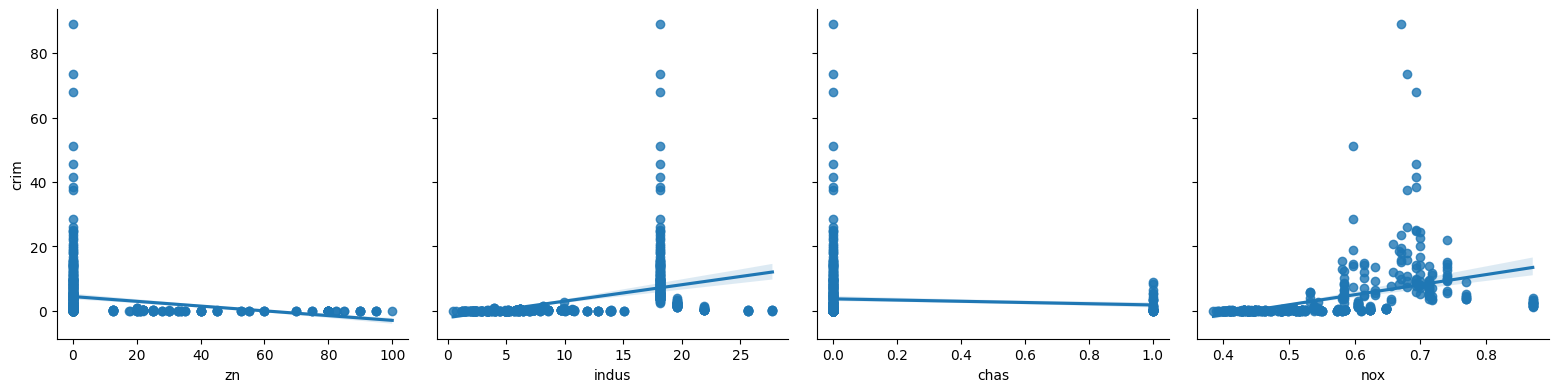

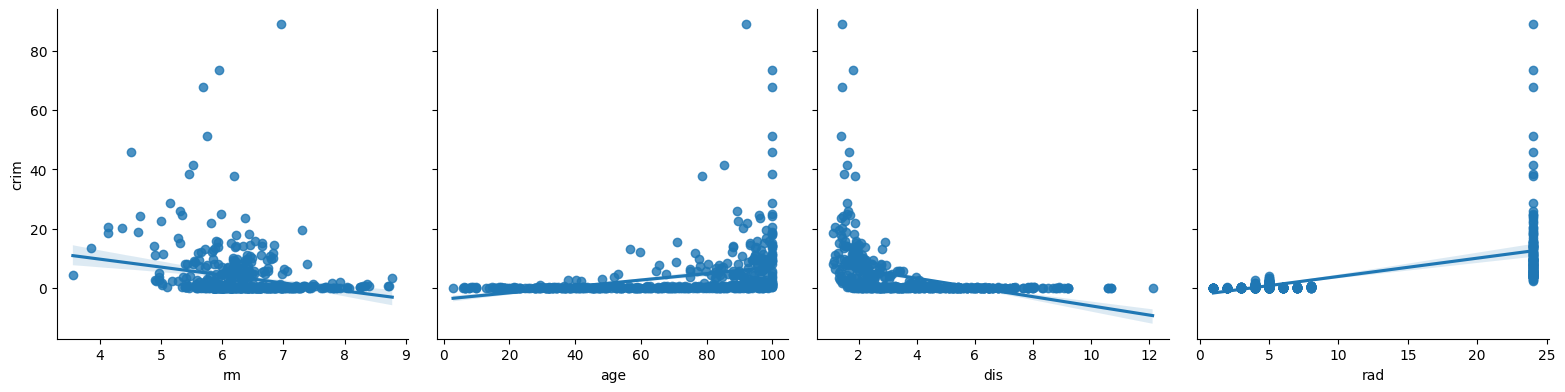

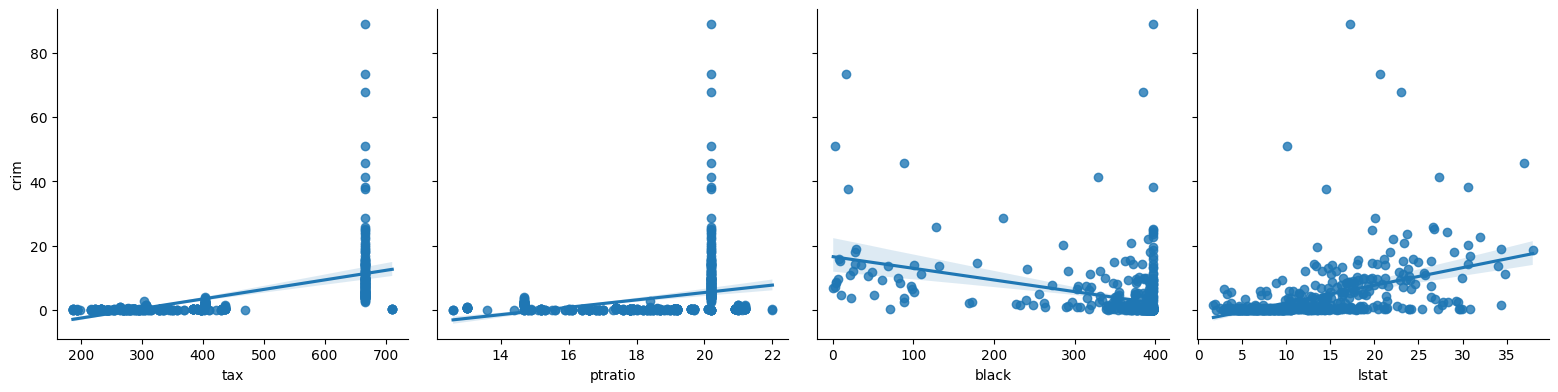

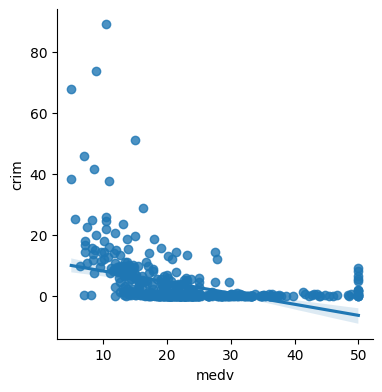

In [50]:
from IPython.display import display, HTML

boston_df = pd.read_csv(
    "https://github.com/pykale/transparentML/raw/main/data/Boston.csv"
)

# Check for missing values
assert boston_df.isnull().sum().sum() == 0

models_a = [smf.ols(formula='crim ~ {}'.format(f), data=boston_df).fit()
            for f in boston_df.columns[1:]]

for model in models_a:
    dp = 4
    display(pd.DataFrame({'coef':    np.around(model.params, dp),
                          'std_err': np.around(model.bse, dp),
                          't':       np.around(model.params / model.bse, dp),
                          'P>|t|':   np.around(model.pvalues, dp),
                          '[0.025':  np.around(model.conf_int(alpha=0.05)[0], dp),
                          '0.975]':  np.around(model.conf_int(alpha=0.05)[1], dp)}))
    
# In which of the models is there a statistically significant association between the predictor and the response?
print("Models which have statistically significant association between the predictor and the response ")
display(HTML('<h3>p < 0.05</h3>'))
for model in models_a:
    if model.pvalues[1] < 0.05:
        print(model.params[1:].index[0])

display(HTML('<h3>p > 0.05</h3>'))
for model in models_a:
    if model.pvalues[1] > 0.05:
        print(model.params[1:].index[0])
        
#Create some plots to back up your assertions.

print("\nSome plots to back up my assertions.")
def plot_grid(df, response, cols):
    """ Plot all predictor variables against response in grid """
    variables = df.columns.drop(response)
    for i in range(0, len(variables), cols):
        g = sns.PairGrid(df, y_vars=[response], x_vars=variables[i:i+cols], height=4)
        g.map(sns.regplot);
    return

plot_grid(boston_df, 'crim', 4)

**b**. Fit a multiple regression model to predict the response using all of the predictors. Describe your results.. FOr which predictors can we reject the null hypothesis $H_0 : \beta_j = 0$ ?

In [ ]:
# Write your code below to answer the question

Compare your answer with the reference solution below

**c**. How do your results from (a) compare to your results form (b)? Create a plot displaying the uni-variate regression coefficients from (a) on the x-axis, and the multiple regression coefficients from (b) on the y-axis. That is, each predictor is displayed as a single point in the plot. Its coefficient in a simple linear regression model is shown on the x-axis, and its coefficient estimate in the multiple linear regression model is shown on the y-axis.


In [ ]:
# Write your code below to answer the question

Compare your answer with the reference solution below

**d**. Is there evidence of non-linear association between any of the predictors and the response? To answer this question, for each predictor X, fit a model of the form,

    $$y = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 + \epsilon$$

In [ ]:
# Write your code below to answer the question

Compare your answer with the reference solution below